## Problem 2

For the down-and-out call option with barrier B and strike price K, once the stock price reaches $B before the option matures, the option automatically expires worthless. 

The parameter are defined as following: 

Maturity T = 1 

Initial asset value X(0) = $50

Strike price K = $55

Risk-free interest rate r = 0.05

Volatility parameter σ^2 = (0.3)^2

To discretizing the Geometric Brownian Motion, every Maturity is divided into 64 steps. Therefore, every Interval till Maturity has time length 1/64. The stock price for every 1/64 is calculated. If the stock price reaches barrier B, the loop will break and the option value will be recorded as zero in this replication. On the contrary, if the stock price remains higher than barrier B, the option value depends only on the final asset value on the expiration date, which is T = 1. If the stock price is higher than the Strike price K, the option worth X(1)-K; if the stock price is lower than or equal to the Strike price K, the option is worthless.

After 40,000 replications are completed, the option value for barrier 35, 40, 45 are recorded in a list. Mean and confidence interval are computed for the option with different barriers. 

The option value with barrier 35 has 95% confidence interval [4.94081615,5.13417261] and mean 5.03749438.

The option value with barrier 40 has 95% confidence interval [4.79612958,4.9887106] and mean 4.89242009.

The option value with barrier 40 has 95% confidence interval [3.79450777,3.975221] and mean 3.88486438.

As the barrier becomes higher, the average option value becomes lower. Since the option with higher barrier will have higher probability of being worthless, the average option value then is likely to be lower. 

In [114]:
import numpy as np

def CI_95(data):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    sd = np.std(a,ddof=1)
    hw = 1.96*sd / np.sqrt(n)
    return m, [m-hw,m+hw]

Maturity = 1.0
InterestRate = 0.05
Sigma = 0.3
InitialValue = 50.0
StrikePrice = 55.0
Steps = 64
Interval = Maturity / Steps
Sigma2 = Sigma * Sigma / 2

np.random.seed(1)
Replications = 40000

Interval = Maturity / Steps


for barrier in (35,40,45):
    ValueList = [] # List to keep the option value for each sample path

    for i in range(0,Replications):

        X = InitialValue
        Value = 1
        for j in range(0,Steps):
            Z = np.random.standard_normal(1)
            X = X * np.exp((InterestRate - Sigma2) * Interval +
                           Sigma * np.sqrt(Interval) * Z)
            # If there's any X value that falls below $B before the option matures then the option is worthless
            if X <= barrier:
                Value = 0
                break
        
        if Value != 0:
            Value = np.exp(-InterestRate * Maturity) * max(X - StrikePrice, 0)
        
        # append 0 if stock price reaches $B or max(X（T） - StrikePrice, 0) if not
        ValueList.append(Value)    

    print ("Mean and CI:", CI_95(ValueList))



Mean and CI: (array([5.03749438]), [array([4.94081615]), array([5.13417261])])
Mean and CI: (array([4.89242009]), [array([4.79612958]), array([4.9887106])])
Mean and CI: (array([3.88486438]), [array([3.79450777]), array([3.975221])])


## Problem 3

The parameter are defined as following:

Arrivals is Poisson arrival process with rate lamda(t) = 1.

Service times are independent and exponentially distributed with mean 0.8*n for n servers.

For every Arrival event, schedule next arrival time, and add a customer to the queue. If there is enough resources available, seize the unit and schedule next departure as "clock + Erlang(0.8)" with label "EndofService". Otherwise, do not seize the unit and the customer remain in the queue. 

For every End of Service event, the queue removes a customer and the system time for the customer is recorded. If there is customer who is in the queue and has not been served, the customer gets the service and the next departure would be scheduled as "clock + Erlang(0.8)" with label "EndofService". 

Expected number of customers in the system is measured by the parameter Queue.Mean, because for every arrival regardless service or not is counted in the queue. The customer is removed out of the queue only when End of Service event happens.

Expected system time is measured by the parameter Wait.Mean in the function, which include the wait time and service time.

Expected number of busy servers is measured by utilization, which is busy server * working time / total time.

### (a)

If there is 1 server:

Estimated Expected Number of Customer in the System: 2.8868458306247526

Estimated Expected System Time: 2.893562002038238

Estimated Expected Number of Busy servers: 0.7980425215215462

If there is 2 servers:

Estimated Expected Number of Customer in the System: 3.1683645766072073

Estimated Expected System Time: 3.1734180362698665

Estimated Expected Number of Busy servers: 1.1961802501940428

If there is 3 servers:

Estimated Expected Number of Customer in the System: 3.497390138394917

Estimated Expected System Time: 3.5040051214395413

Estimated Expected Number of Busy servers: 1.5948518543153436

### (b)

As the server gets more, the expected number of customer in the system gets larger; the expected system time. If there are more servers, the average service time gets larger and the service efficiency gets lower. Therefore, more customers spend more time waiting in queue while the arrival process remains the same. 

In [118]:
import SimFunctions
import SimRNG 
import SimClasses
import numpy as np
import pandas


ZSimRNG = SimRNG.InitializeRNSeed()

Queue = SimClasses.FIFOQueue()
Wait = SimClasses.DTStat()
System = SimClasses.DTStat()
Server = SimClasses.Resource()
Calendar = SimClasses.EventCalendar()

TheCTStats = []
TheDTStats = []
TheQueues = []
TheResources = []

TheDTStats.append(Wait)
TheQueues.append(Queue)
TheResources.append(Server)

MeanTBA = 1.0
Phases = 3
RunLength = 55000.0
WarmUp = 5000.0

AllWaitMean = []
AllQueueMean = []
AllQueueNum = []
AllServerMean = []


def Arrival():   
    SimFunctions.Schedule(Calendar,"Arrival",SimRNG.Expon(MeanTBA, 1))
    Customer = SimClasses.Entity()
    Queue.Add(Customer)
    
    if Server.Seize(1):
        SimFunctions.Schedule(Calendar,"EndOfService",SimRNG.Erlang(Phases,MeanST,2))
        
def EndOfService():    
    DepartingCustomer = Queue.Remove()
    Wait.Record(SimClasses.Clock - DepartingCustomer.CreateTime)
    
    if Queue.NumQueue() >= n:
        SimFunctions.Schedule(Calendar,"EndOfService",SimRNG.Erlang(Phases,MeanST,2))
    else:
        Server.Free(1)

for n in (1,2,3): 
    Server.SetUnits (n) 
    MeanST = 0.8*n # setting mean service time
    for reps in range(0,10,1):
        SimFunctions.SimFunctionsInit(Calendar,TheQueues,TheCTStats,TheDTStats,TheResources)
        SimFunctions.Schedule(Calendar,"Arrival",SimRNG.Expon(MeanTBA, 1))
        SimFunctions.Schedule(Calendar,"EndSimulation",RunLength)
        SimFunctions.Schedule(Calendar,"ClearIt",WarmUp)

        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == "Arrival":
            Arrival()
        elif NextEvent.EventType == "EndOfService":
            EndOfService() 
        elif NextEvent.EventType == "ClearIt":
            SimFunctions.ClearStats(TheCTStats,TheDTStats)

        while NextEvent.EventType != "EndSimulation":
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            if NextEvent.EventType == "Arrival":
                Arrival()
            elif NextEvent.EventType == "EndOfService":
                EndOfService()
            elif NextEvent.EventType == "ClearIt":
                SimFunctions.ClearStats(TheCTStats,TheDTStats)


        AllWaitMean.append(Wait.Mean())
        AllQueueMean.append(Queue.Mean())
        AllServerMean.append(Server.Mean())
        
    # output results    
    print("Estimated Expected Number of Customer in the System:", np.mean(AllQueueMean))
    print("Estimated Expected System Time:", np.mean(AllWaitMean))
    print("Estimated Expected Number of Busy servers:",np.mean(AllServerMean))
    

Estimated Expected Number of Customer in the System: 2.933449953751253
Estimated Expected System Time: 2.9292775509318028
Estimated Expected Number of Busy servers: 0.8010104508355139
Estimated Expected Number of Customer in the System: 3.231218377659419
Estimated Expected System Time: 3.2298054936411114
Estimated Expected Number of Busy servers: 1.200654865113195
Estimated Expected Number of Customer in the System: 3.5398257773357757
Estimated Expected System Time: 3.5404592572946387
Estimated Expected Number of Busy servers: 1.6002388196181794


## Problem 4

For the M/G/1/c retrial queue that has c = 4, if any customer sees there are 4 people ahead, he will leave immediately and return. In this case, schedule another arrival event that follows distribution SimRNG.Expon(MeanTR, 3). If there are less than 4 people ahead, add the customer into the queue and schedule next arrival as SimRNG.Expon(MeanTBA, 1). 

Afterwards, if there is enough resources available, seize the unit and schedule next departure as "clock + Erlang(mean=0.8)" with label "EndofService". Otherwise, do not seize the unit and the customer remain in the queue. Same as previous question, for every end of service event, the queue removes a customer and the system time for the departured customer is recorded. If there is customer who is in the queue and has not been served, the next departure would be scheduled as "clock + Erlang(mean=0.8)" with label "EndofService".

I set average service time 0.8 and 3 to see if service time need to smaller than arrival rate for the system to reach steady-state.

I created a list called WaitRecord that can store the mean of waiting time for every additional customer. Since Wait.Record in DTStat is summing up the additional waiting time, I calculated the mean each time when Wait.Record sums up the additional customer. In this case, I plot first 400 value from the WaitRecord list to see if the waiting time converges to a constant. 

As the plot shown, the waiting time always converges to a constant regardless of the average service time.

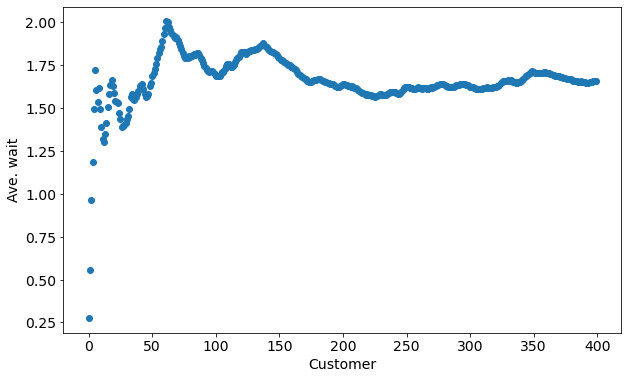

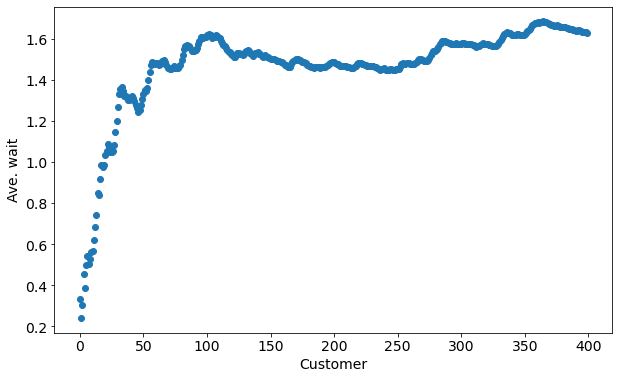

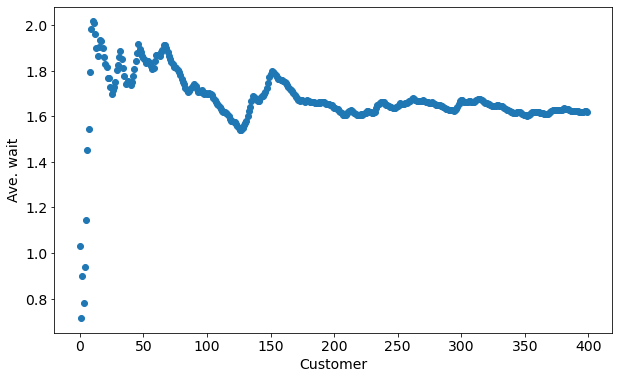

Estimated Expected Average system time: 1.6413642202878147
Estimated Expected Average queue-length: 1.5025705300222614
Estimated Expected Average utilization: 0.7304717464245053


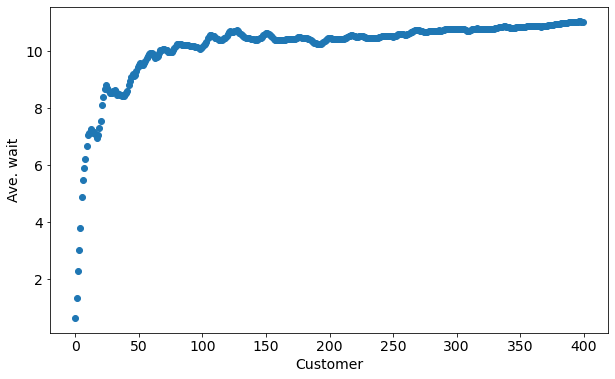

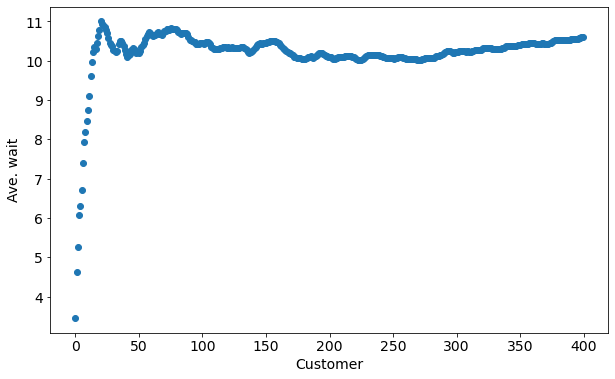

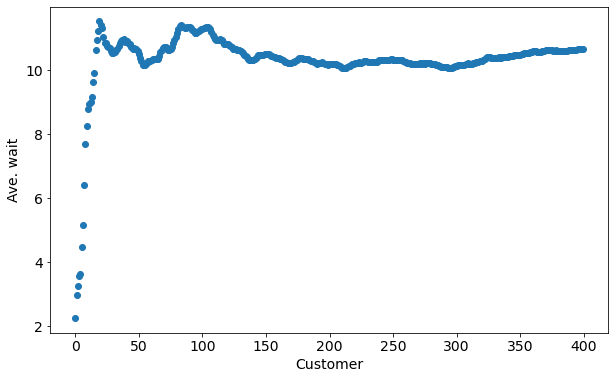

Estimated Expected Average system time: 6.230795063965783
Estimated Expected Average queue-length: 2.5534808982563404
Estimated Expected Average utilization: 0.8647508456168597


In [146]:
import SimFunctions
import SimRNG 
import SimClasses
import numpy as np
import pandas
import matplotlib.pyplot as plt

ZSimRNG = SimRNG.InitializeRNSeed()

Queue = SimClasses.FIFOQueue()
Wait = SimClasses.DTStat()
Server = SimClasses.Resource()
Calendar = SimClasses.EventCalendar()

TheCTStats = []
TheDTStats = []
TheQueues = []
TheResources = []

TheDTStats.append(Wait)
TheQueues.append(Queue)
TheResources.append(Server)

Server.SetUnits (1)
MeanTBA = 1.0
MeanTR = 1.0
Phases = 3
RunLength = 55000.0
WarmUp = 5000.0
c = 4

AllWait = []
AllWaitMean = []
AllQueueMean = []
AllQueueNum = []
AllServerMean = []


def Arrival():
    Customer = SimClasses.Entity()
    if Queue.NumQueue() >= c: # set retrial customer as stream 3
        SimFunctions.Schedule(Calendar,"Arrival",SimRNG.Expon(MeanTR, 3))
    else: # set first time customer as stream 1
        SimFunctions.Schedule(Calendar,"Arrival",SimRNG.Expon(MeanTBA, 1))
        Queue.Add(Customer)
       
    if Server.Busy == 0:
        Server.Seize(1)
        SimFunctions.Schedule(Calendar,"EndOfService",SimRNG.Erlang(Phases,MeanST,2))

def EndOfService():
    DepartingCustomer = Queue.Remove()
    Wait.Record(SimClasses.Clock - DepartingCustomer.CreateTime)
    WaitRecord.append(Wait.Mean()) # the mean for every additional customer 
    if Queue.NumQueue() > 0:
        SimFunctions.Schedule(Calendar,"EndOfService",SimRNG.Erlang(Phases,MeanST,2))
    else:
        Server.Free(1)

for rate in (0.8, 3): # comparing the service mean time that is less than or bigger than arrival mean time
    MeanST = rate
    
    for reps in range(0,3,1): # 3 plots for average service time 0.8 and 3 respectively
        WaitRecord = [] # create a list to store the mean of wait time for every additional customer

        SimFunctions.SimFunctionsInit(Calendar,TheQueues,TheCTStats,TheDTStats,TheResources)
        SimFunctions.Schedule(Calendar,"Arrival",SimRNG.Expon(MeanTBA, 1))
        SimFunctions.Schedule(Calendar,"EndSimulation",RunLength)
        SimFunctions.Schedule(Calendar,"ClearIt",WarmUp)


        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == "Arrival":
            Arrival()
        elif NextEvent.EventType == "EndOfService":
            EndOfService() 
        elif NextEvent.EventType == "ClearIt":
            SimFunctions.ClearStats(TheCTStats,TheDTStats)

        while NextEvent.EventType != "EndSimulation":
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            if NextEvent.EventType == "Arrival":
                Arrival()
            elif NextEvent.EventType == "EndOfService":
                EndOfService()
            elif NextEvent.EventType == "ClearIt":
                SimFunctions.ClearStats(TheCTStats,TheDTStats)


        AllWaitMean.append(Wait.Mean())
        AllQueueMean.append(Queue.Mean())
        AllServerMean.append(Server.Mean())


        plt.plot(np.array(WaitRecord[:400]),'o') # show first 400 customer average waiting time
        plt.xlabel('Customer')
        plt.ylabel('Ave. wait')
        plt.rcParams['figure.figsize'] = (10, 6)
        plt.rcParams.update({'font.size': 14})
        plt.show()


    # output results
    print("Estimated Expected Average system time:",np.mean(AllWaitMean))
    print("Estimated Expected Average queue-length:", np.mean(AllQueueMean))
    print("Estimated Expected Average utilization:",np.mean(AllServerMean))


## Problem 5(a)

Since 170 staffs arrived between 6:30AM and 7AM, I scheduled arrival events for all 170 staff to the calendar at the beginning of each replication. The arrival process follows uniform distribution from time 0 to 30. After all arrival events are set, the service begins from time 30. The servers are constantly busy until all 170 staff finished serving. Therefore, end simulation event happens when there are no more staff in the queue.

The following result is the expected system time.

Estimated Expected Average System Time: 119.51866481320315

Mean and CI: (119.51866481320315, [118.34350277458698, 120.69382685181931])

Since the expected service time is 15, according to E[Time in System]=E[Wait in Queue]+E[Service Time], E[Wait in Queue] = E[Time in System] - E[Service Time] = E[Time in System] - 15.

Therefore, the expected wait time is as following.

Estimated Expected Waiting Time: 104.51866481320315

Mean and CI: (104.51866481320315, [103.34350277458698, 105.69382685181931])

In [136]:
import SimFunctions
import SimRNG 
import SimClasses
import numpy as np
import pandas


def CI_95(data):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    sd = np.std(a,ddof=1)
    hw = 1.96*sd / np.sqrt(n)
    return m, [m-hw,m+hw]


ZSimRNG = SimRNG.InitializeRNSeed()

Queue = SimClasses.FIFOQueue()
Wait = SimClasses.DTStat()
Server = SimClasses.Resource()
Calendar = SimClasses.EventCalendar()

TheCTStats = []
TheDTStats = []
TheQueues = []
TheResources = []

TheDTStats.append(Wait)
TheQueues.append(Queue)
TheResources.append(Server)

Server.SetUnits (10) # set 10 servers
MeanST = 15
Phases = 4

AllWaitMean = []
AllQueueMean = []
AllQueueNum = []
AllServerMean = []

def Arrival():   
    Customer = SimClasses.Entity()
    Queue.Add(Customer)
    
    if Server.Seize(1):
        SimFunctions.Schedule(Calendar,"EndOfService",SimRNG.Erlang(Phases,MeanST,2))

def EndOfService():    
    DepartingCustomer = Queue.Remove()
    Wait.Record(SimClasses.Clock - DepartingCustomer.CreateTime)
    if Queue.NumQueue() >= 10:

        SimFunctions.Schedule(Calendar,"EndOfService",SimRNG.Erlang(Phases,MeanST,2))
    else:
        Server.Free(1)
    
    if Queue.NumQueue() == 0: # no more staff in the queue
        SimFunctions.Schedule(Calendar,"EndSimulation",RunLength)

        
for reps in range(0,100,1):
    SimFunctions.SimFunctionsInit(Calendar,TheQueues,TheCTStats,TheDTStats,TheResources)
    
    for n in range(170): # schedule 170 arrival events
        SimFunctions.Schedule(Calendar,"Arrival",SimRNG.Uniform(0, 30, 1))

    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == "Arrival":
        Arrival()
    elif NextEvent.EventType == "EndOfService":
        EndOfService() 
    
    while NextEvent.EventType != "EndSimulation":
        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == "Arrival":
            Arrival()
        elif NextEvent.EventType == "EndOfService":
            EndOfService()

    
    AllWaitMean.append(Wait.Mean())

# Expected System time
print ("Estimated Expected System Time:",np.mean(AllWaitMean))
print ("Mean and CI:", CI_95(AllWaitMean))

# Expected Wait time will be Expected System time - 15

Estimated Expected System Time: 119.56905410447558
Mean and CI: (119.56905410447558, [118.43997098221409, 120.69813722673707])


## Problem 5(b)

By testing from 30 to 40, I found that approximately 36 servers are needed to keep the average waiting time below 15 minutes.

Estimated Expected Average wait: 14.558673770780633

Mean and CI: (14.558673770780633, [14.191063881943734, 14.926283659617532])

In [144]:
import SimFunctions
import SimRNG 
import SimClasses
import numpy as np
import pandas


def CI_95(data):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    sd = np.std(a,ddof=1)
    hw = 1.96*sd / np.sqrt(n)
    return m, [m-hw,m+hw]


ZSimRNG = SimRNG.InitializeRNSeed()

Queue = SimClasses.FIFOQueue()
Wait = SimClasses.DTStat()
Server = SimClasses.Resource()
Calendar = SimClasses.EventCalendar()

TheCTStats = []
TheDTStats = []
TheQueues = []
TheResources = []

TheDTStats.append(Wait)
TheQueues.append(Queue)
TheResources.append(Server)

Server.SetUnits (36) 
MeanST = 15
Phases = 4

AllWaitMean = []
AllQueueMean = []
AllQueueNum = []
AllServerMean = []

def Arrival():   
    Customer = SimClasses.Entity()
    Queue.Add(Customer)
    
    if Server.Seize(1):
        SimFunctions.Schedule(Calendar,"EndOfService",SimRNG.Erlang(Phases,MeanST,2))

def EndOfService():    
    DepartingCustomer = Queue.Remove()
    Wait.Record(SimClasses.Clock - DepartingCustomer.CreateTime)
    
    if Queue.NumQueue() >= 36:
        SimFunctions.Schedule(Calendar,"EndOfService",SimRNG.Erlang(Phases,MeanST,2))
    else:
        Server.Free(1)
    
    if Queue.NumQueue() == 0: # no more staff in the queue
        SimFunctions.Schedule(Calendar,"EndSimulation",RunLength)

for reps in range(0,100,1):
    SimFunctions.SimFunctionsInit(Calendar,TheQueues,TheCTStats,TheDTStats,TheResources)
    
    for n in range(170): # schedule 170 arrival events
        SimFunctions.Schedule(Calendar,"Arrival",SimRNG.Uniform(0, 30, 1))
        
    
    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == "Arrival":
        Arrival()
    elif NextEvent.EventType == "EndOfService":
        EndOfService() 
    
    while NextEvent.EventType != "EndSimulation":
        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == "Arrival":
            Arrival()
        elif NextEvent.EventType == "EndOfService":
            EndOfService()

    
    AllWaitMean.append(Wait.Mean())  

# output results
print("Estimated Expected System time:",np.mean(AllWaitMean))
print ("Mean and CI:", CI_95(AllWaitMean))

# Expected Wait time will be Expected System time - 15

Estimated Expected Average wait: 29.558673770780633
Mean and CI: (29.558673770780633, [29.191063881943734, 29.926283659617532])
